In [1]:
import sys
from pathlib import Path
import warnings

warnings.filterwarnings("ignore", module="IPython")


def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False


def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book


def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml


if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip subdirectories from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ("src",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("airquality",):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ("notebooks",):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir)
    print("Local environment")

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH`
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

# Set the environment variables from the file <root_dir>/.env
from src import config

settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Root dir: /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn
Added the following directory to the PYTHONPATH: /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn
HopsworksSettings initialized!


In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from src.airquality import util
import json

import warnings

warnings.filterwarnings("ignore")

# Setup

In [3]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ["HOPSWORKS_API_KEY"] = api_key
project = hopsworks.login(engine="python")
fs = project.get_feature_store()

secrets = hopsworks.get_secrets_api()
locations_str = secrets.get_secret("SENSOR_LOCATIONS_JSON").value
locations = json.loads(locations_str)


# Retrieve feature groups
air_quality_fg = fs.get_feature_group(
    name="air_quality_all",
    version=1,
)
weather_fg = fs.get_feature_group(
    name="weather_all",
    version=1,
)

# Select features for training data.
selected_features = air_quality_fg.select(["pm25", "date"]).join(
    weather_fg.select_features(), on=["sensor_id"]
)


feature_view = fs.get_or_create_feature_view(
    name="air_quality_fv",
    description="weather features with air quality as the target",
    version=1,
    labels=["pm25"],
    query=selected_features,
)


start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

2025-11-12 14:21:12,871 INFO: Initializing external client
2025-11-12 14:21:12,873 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-12 14:21:14,558 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1279172
2025-11-12 14:21:16,806 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant', 'city', 'latitude', 'longitude'] from feature group `weather_all` as features for the query. To include primary key and event time use `select_all`.


In [4]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(test_start=test_start)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.25s) 


In [5]:
X_train.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,latitude,longitude
0,2019-12-09 00:00:00+00:00,4.256583,1.600000,29.743059,244.077133,Majorna-Linné,57.698,11.946
1,2019-12-10 00:00:00+00:00,0.904500,1.000000,36.862663,175.034027,Majorna-Linné,57.698,11.946
2,2019-12-11 00:00:00+00:00,5.264916,12.200001,37.842831,194.964493,Majorna-Linné,57.698,11.946
3,2019-12-12 00:00:00+00:00,3.894084,1.000000,18.079027,167.420441,Majorna-Linné,57.698,11.946
4,2019-12-13 00:00:00+00:00,2.860750,0.000000,18.218275,116.806824,Majorna-Linné,57.698,11.946


In [20]:
X_features = X_train.drop(columns=["date", "city"])
X_test_features = X_test.drop(columns=["date", "city"])

In [21]:
X_features.head()

,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,latitude,longitude
0,4.256583,1.600000,29.743059,244.077133,57.698,11.946
1,0.904500,1.000000,36.862663,175.034027,57.698,11.946
2,5.264916,12.200001,37.842831,194.964493,57.698,11.946
3,3.894084,1.000000,18.079027,167.420441,57.698,11.946
4,2.860750,0.000000,18.218275,116.806824,57.698,11.946


In [22]:
y_train.head()

,pm25
0,0.83
1,0.88
2,2.04
3,2.82
4,3.74


In [23]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [24]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:, 0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:, 0], y_pred)
print("R squared:", r2)

MSE: 87.53136472072897
R squared: -6.885882711782062


In [25]:
df = y_test.copy()
df["predicted_pm25"] = y_pred

In [26]:
X_test.head()

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant,city,latitude,longitude
1930,2025-05-01 00:00:00+00:00,12.329499,0.2,17.100000,189.290405,Majorna-Linné,57.698,11.946
1931,2025-05-02 00:00:00+00:00,10.748250,2.1,29.876204,256.040955,Majorna-Linné,57.698,11.946
1932,2025-05-03 00:00:00+00:00,9.442000,2.6,21.780743,269.116364,Majorna-Linné,57.698,11.946
1933,2025-05-04 00:00:00+00:00,7.221167,0.4,24.375216,23.926826,Majorna-Linné,57.698,11.946
1934,2025-05-05 00:00:00+00:00,7.725334,0.0,22.603443,253.336426,Majorna-Linné,57.698,11.946


In [27]:
df[["date", "latitude", "longitude"]] = X_test[["date", "latitude", "longitude"]]
df = df.sort_values(by=["date"])
df.head(5)

,pm25,predicted_pm25,date,latitude,longitude
1930,4.34,3.714719,2025-05-01 00:00:00+00:00,57.698000,11.946000
28034,3.08,1.729054,2025-05-01 00:00:00+00:00,57.670000,12.006000
26439,7.73,7.235127,2025-05-01 00:00:00+00:00,57.678940,11.976321
6054,6.53,4.192017,2025-05-01 00:00:00+00:00,57.648728,12.008352
24633,6.40,5.408084,2025-05-01 00:00:00+00:00,57.696000,11.950000


In [28]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

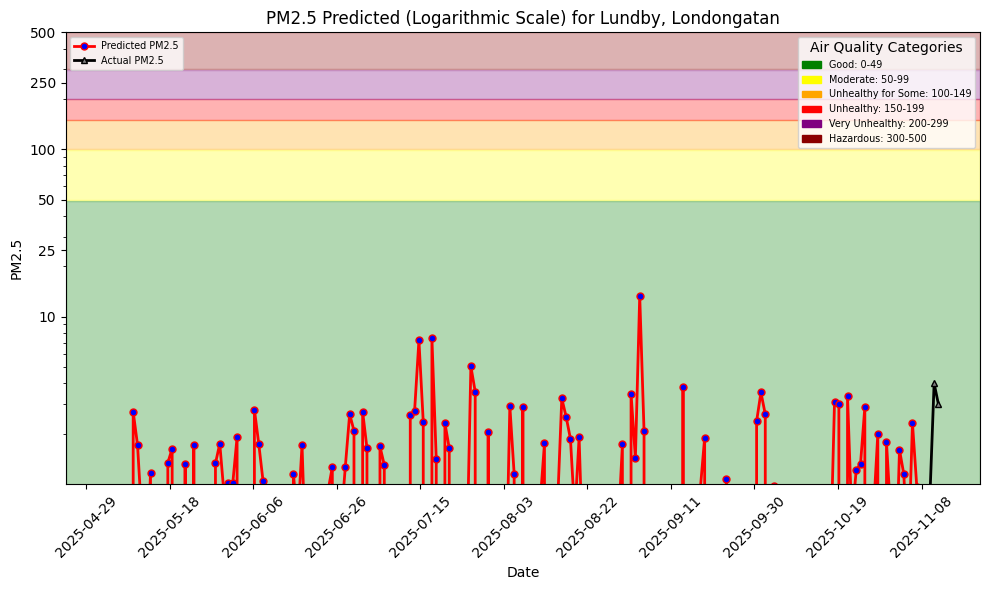

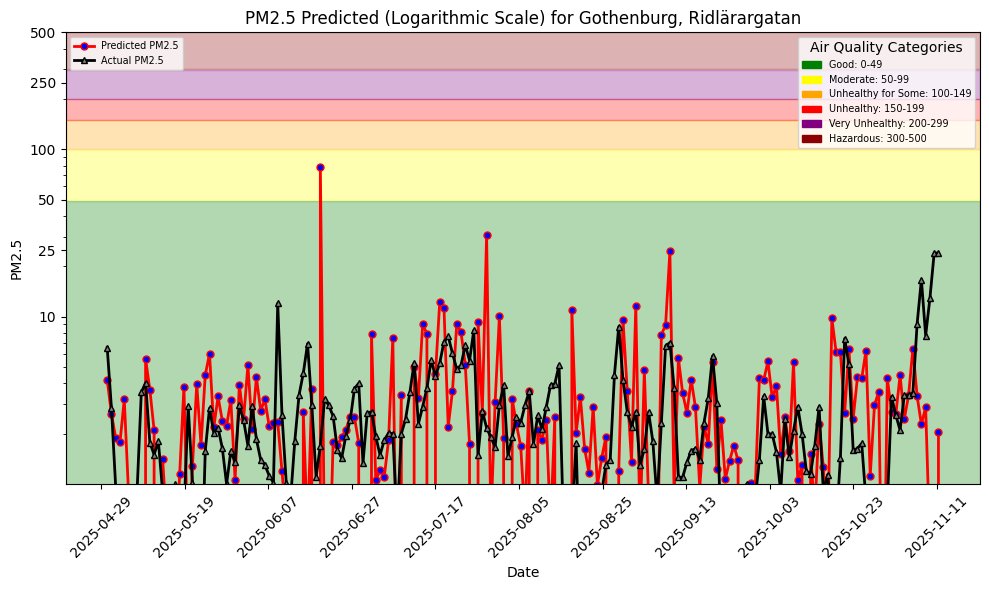

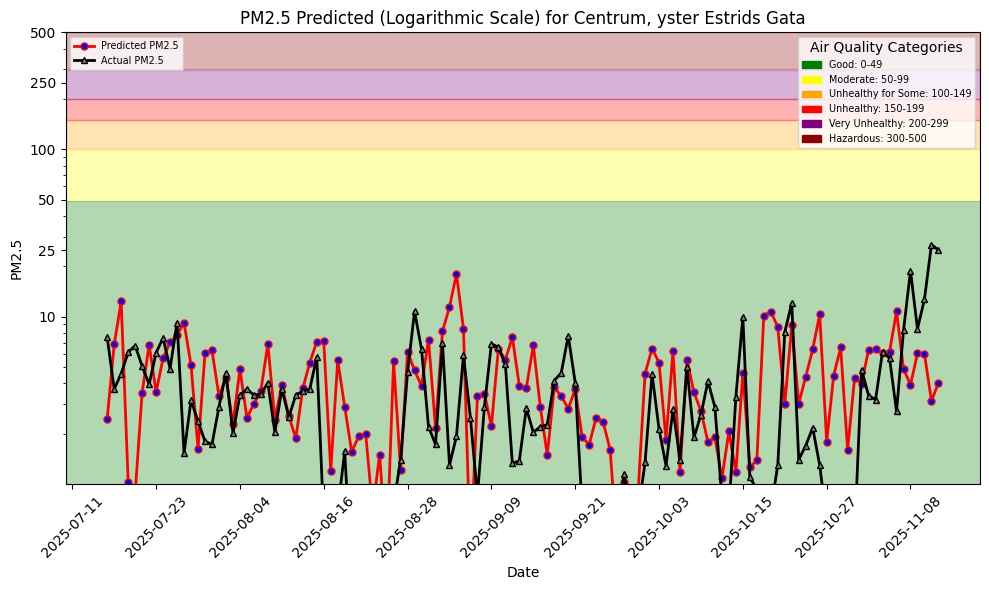

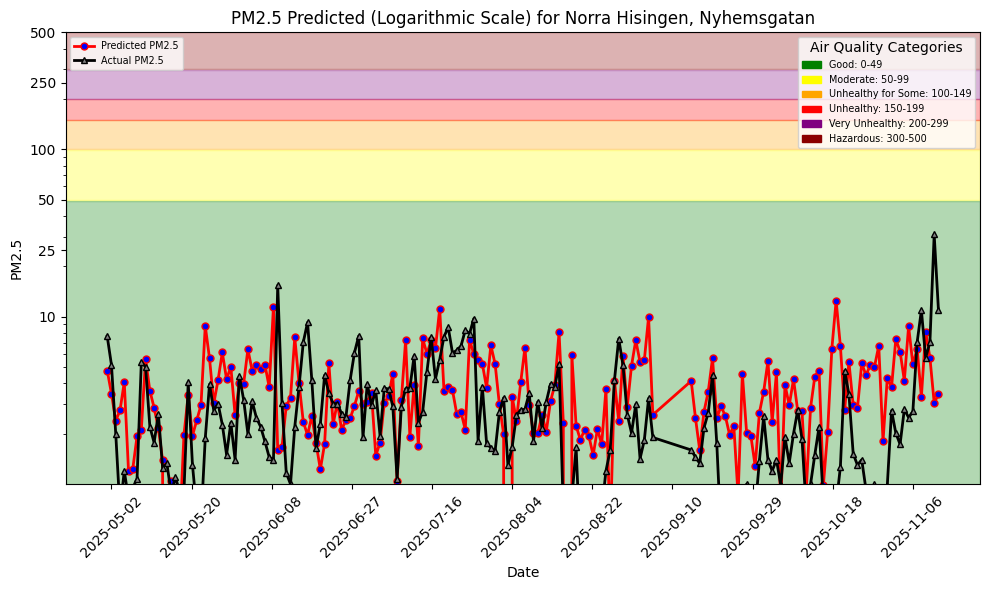

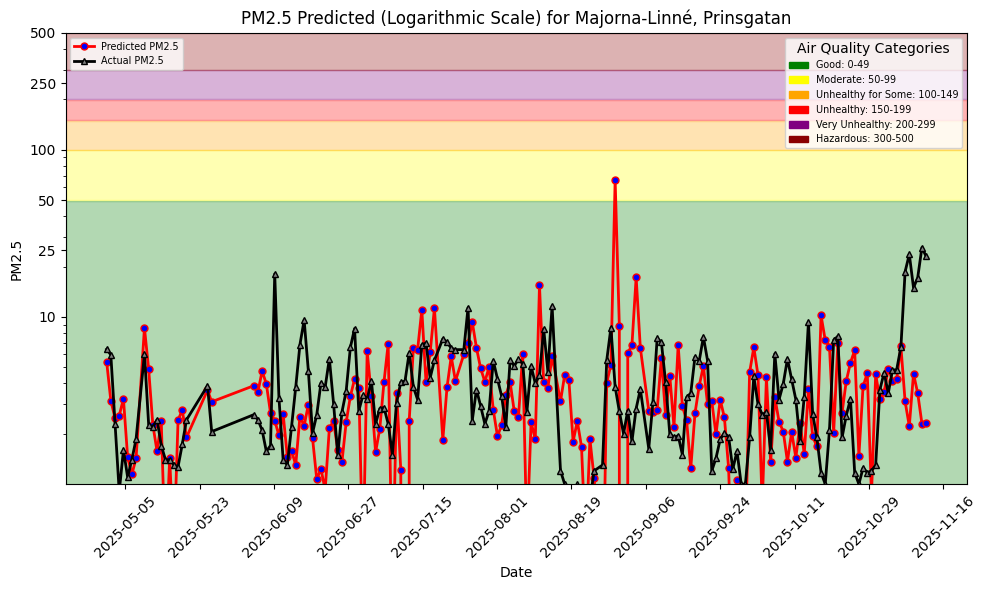

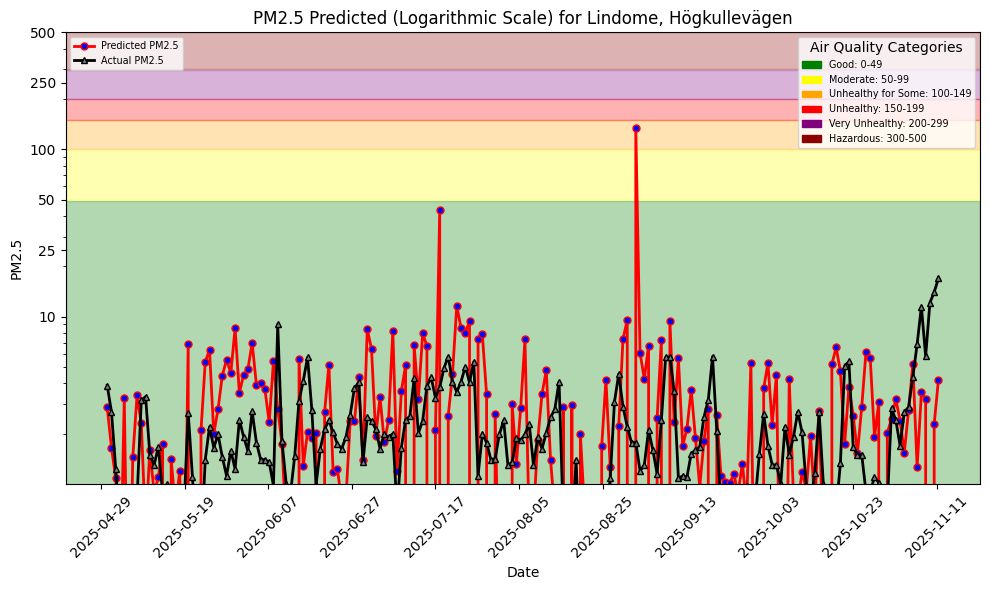

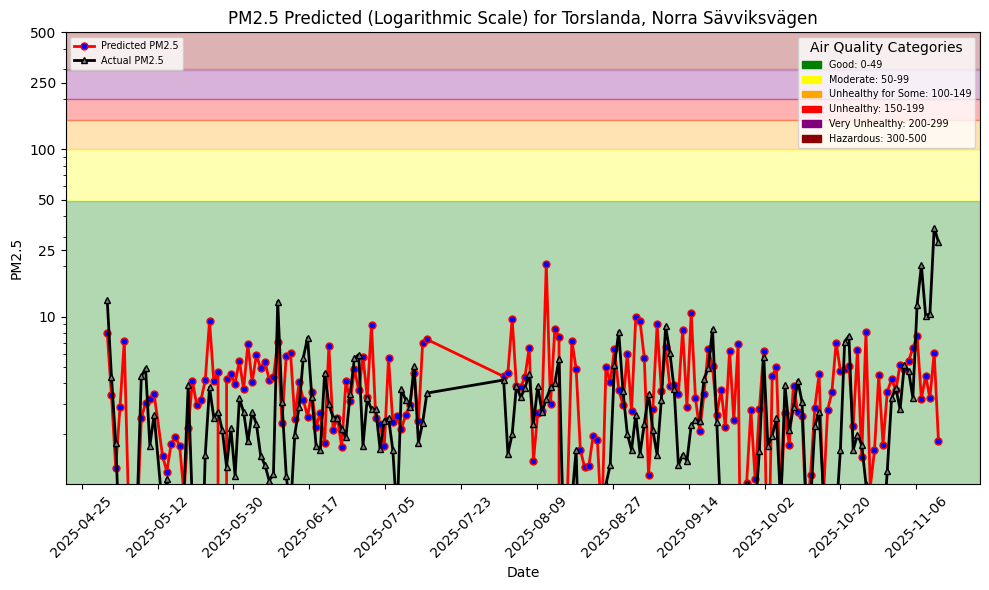

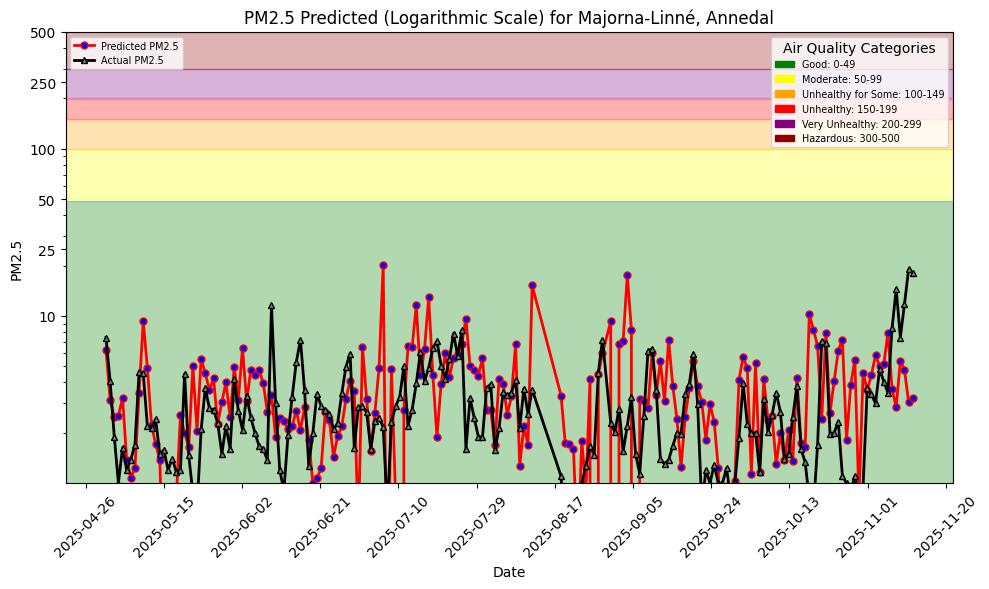

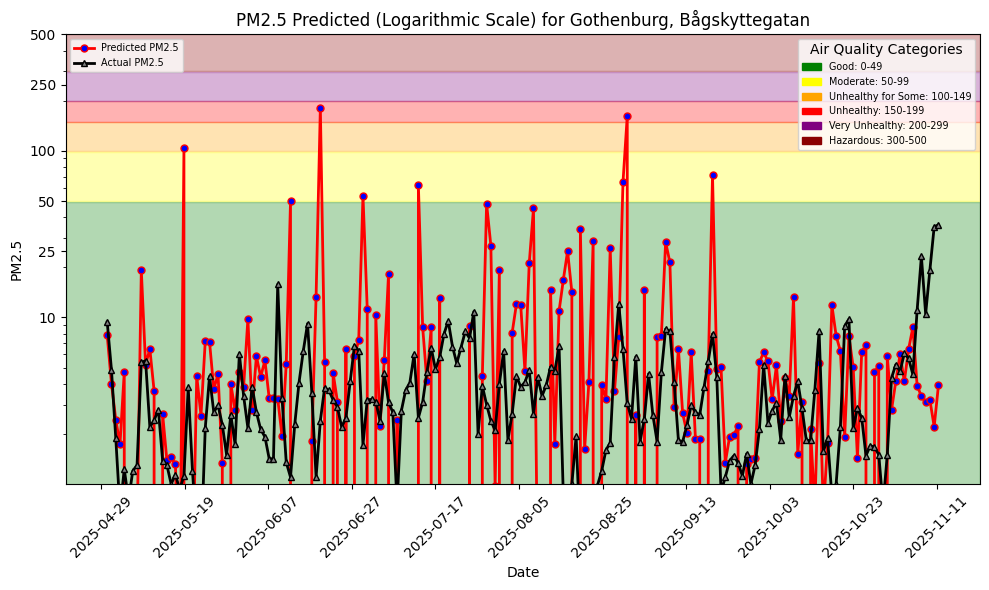

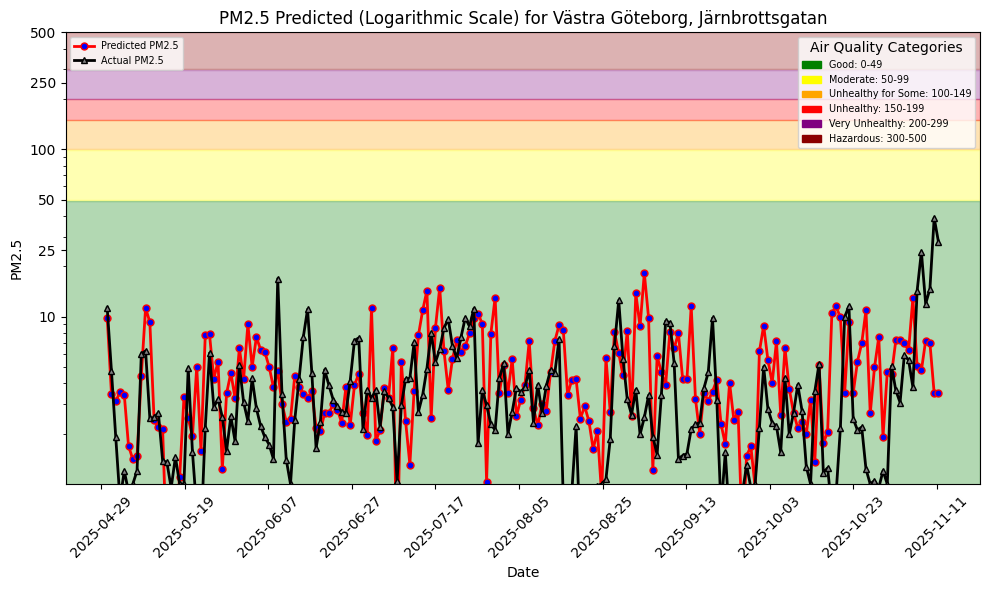

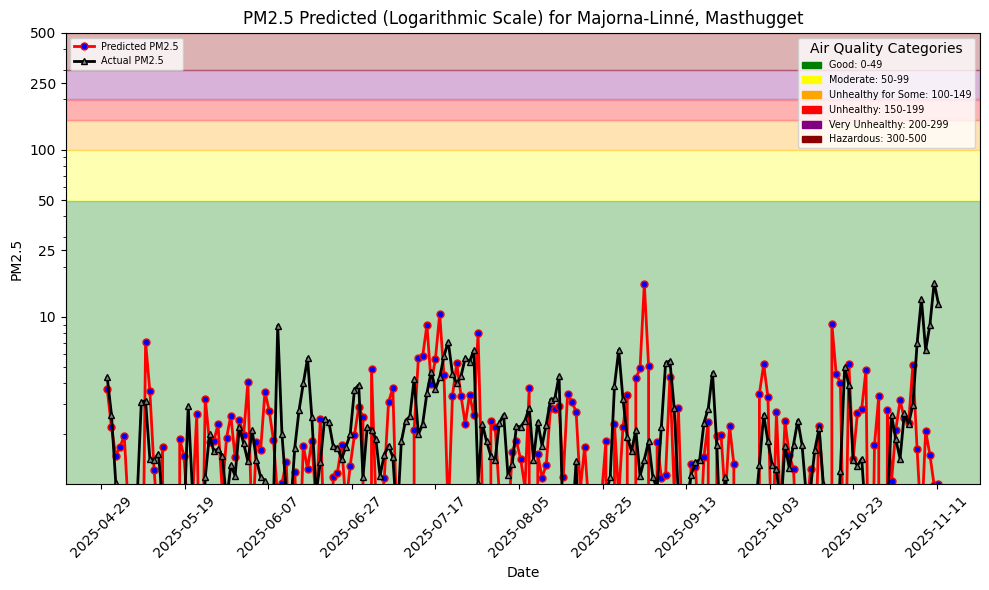

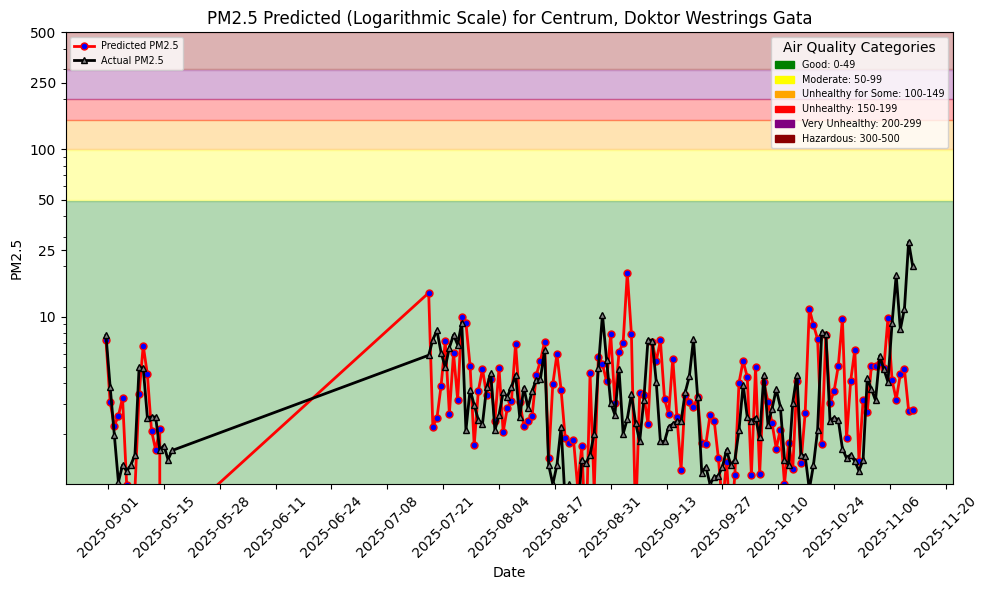

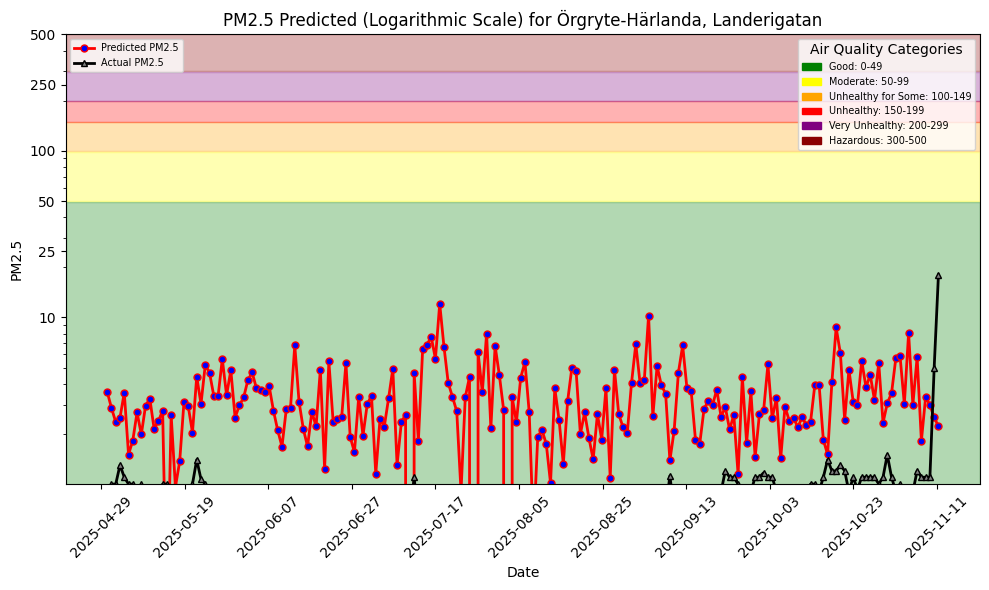

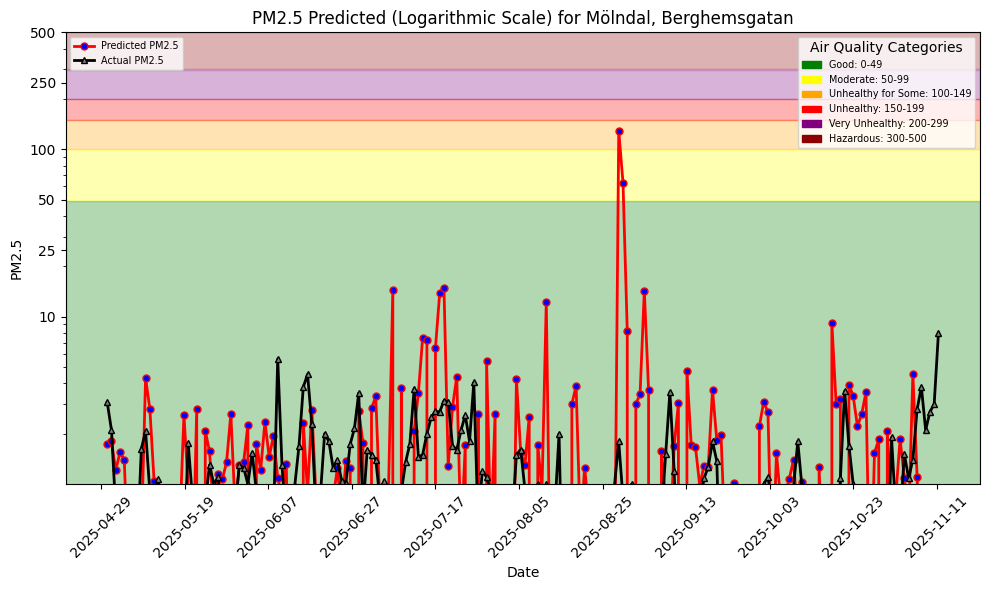

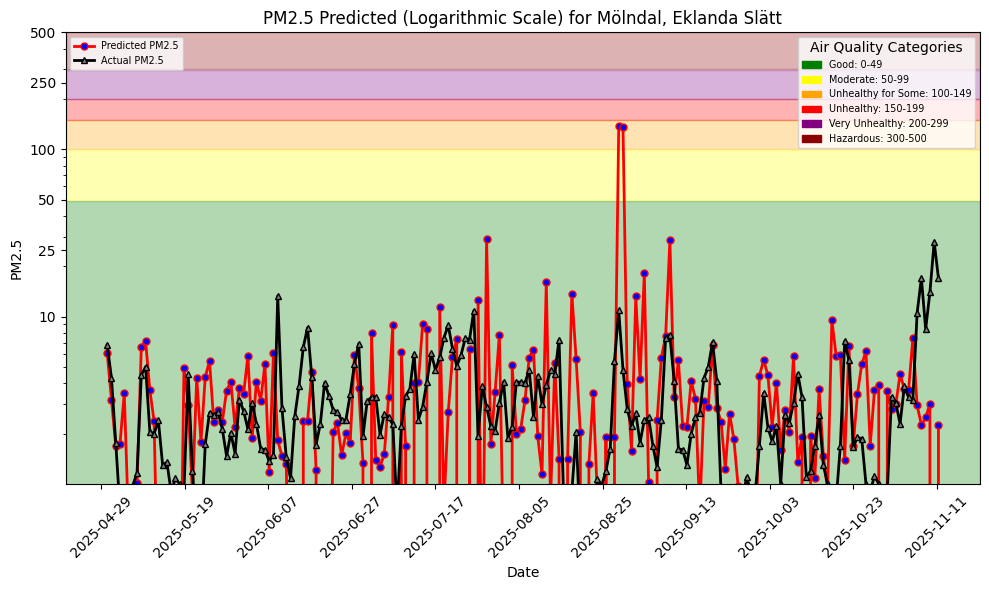

In [29]:
file_paths = []
for id, location in locations.items():
    city = location["city"]
    street = location["street"]
    latitude = location["latitude"]
    longitude = location["longitude"]
    df_subset = df[df["latitude"] == latitude]
    df_subset = df_subset[df_subset["longitude"] == longitude]
    df_subset = df_subset.sort_values(by=["date"])
    df_subset.drop(["latitude", "longitude"], axis=1, inplace=True)
    file_path = images_dir + f"/pm25_{city}_{street}_hindcast.png"
    plt = util.plot_air_quality_forecast(
        city, street, df_subset, file_path, hindcast=True
    )
    plt.show()
    file_paths.append(file_path)

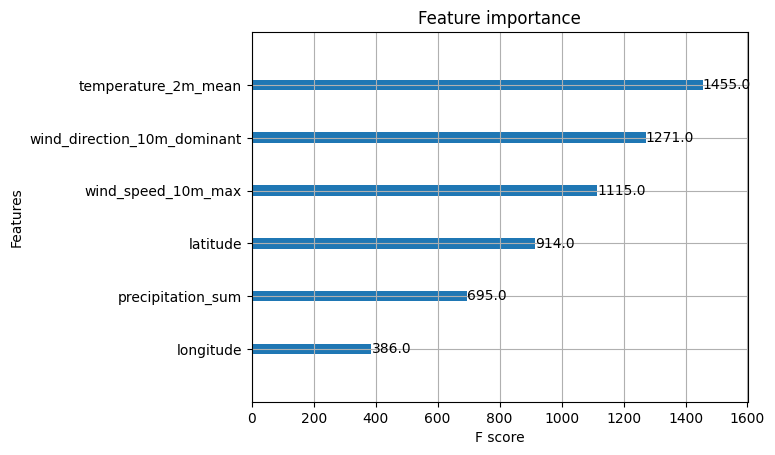

In [30]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [31]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")

In [32]:
res_dict = {
    "MSE": str(mse),
    "R squared": str(r2),
}

In [33]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'
aq_model = mr.python.create_model(
    name="air_quality_xgboost_model",
    metrics=res_dict,
    feature_view=feature_view,
    description="Air Quality (PM2.5) predictor",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/model.json: 0.00…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Lind…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Möln…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Möln…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Goth…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Väst…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/feature_i…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Majo…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Lund…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Norr…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Tors…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Cent…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Örgr…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Majo…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Cent…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Majo…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/air_quality_model/images/pm25_Goth…

Uploading /Users/filipsjostrand/School/id2223/pm25-forecast-openmeteo-aqicn/model_schema.json: 0.000%|        …

Model created, explore it at https://c.app.hopsworks.ai:443/p/1279172/models/air_quality_xgboost_model/2


Model(name: 'air_quality_xgboost_model', version: 2)